# Horse vs Human classification but with augmentation

Applying data augmentation requires good understanding of your dataset. Simply transforming it randomly will not always yield good results because additional training data generated might still do not represent the features in the validation data.

For example, some human or horse poses in the validation set cannot be mimicked by the image processing techniques that `ImageDataGenerator` provides. It might also be that the background of the training images are also learned so the white background of the validation set is throwing the model off even with cropping.

note: the background for all validation images are white background

Let us try augmenting human vs horse dataset and see the result

ref:

 - https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C2/W2/ungraded_labs/C2_W2_Lab_2_horses_v_humans_augmentation.ipynb

In [1]:
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory # 'tis a function
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from google.colab import files
     

## functions

In [21]:
def create_model():
  ## set seed so that model has same 'common ground' (it node's weight and bias are the same value on each creation)
  tf.random.set_seed(10)
  '''Creates a CNN with 4 convolutional layers'''
  model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])
  
  return model


def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()  

## download dataset

In [3]:
# Download the training set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Download the validation set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

--2022-12-21 10:00:47--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 172.253.114.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M   151MB/s    in 0.9s    

2022-12-21 10:00:48 (151 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]

--2022-12-21 10:00:48--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 172.253.114.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114

In [4]:
# Extract the archive
zip_ref = zipfile.ZipFile('./horse-or-human.zip', 'r')
zip_ref.extractall('tmp/horse-or-human')

zip_ref = zipfile.ZipFile('./validation-horse-or-human.zip', 'r')
zip_ref.extractall('tmp/validation-horse-or-human')

zip_ref.close()

# Directory with training horse pictures
train_horse_dir = os.path.join('tmp/horse-or-human/horses')

# Directory with training human pictures
train_human_dir = os.path.join('tmp/horse-or-human/humans')

# Directory with training horse pictures
validation_horse_dir = os.path.join('tmp/validation-horse-or-human/horses')

# Directory with training human pictures
validation_human_dir = os.path.join('tmp/validation-horse-or-human/humans')

In [14]:
# create generator that standardize pixel values
train_datagen = ImageDataGenerator( samplewise_center=True, samplewise_std_normalization=True,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
# of course we don't augment the validation dataset because it supposedly reflect outside or real life data
test_datagen  = ImageDataGenerator( samplewise_center=True, samplewise_std_normalization=True )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        'tmp/validation-horse-or-human/',
        target_size=(300, 300),
        batch_size=32,
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


(300, 300, 3)


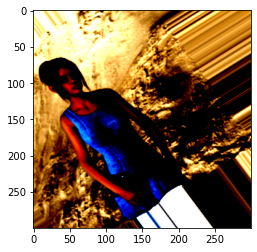

In [17]:
## checking images

batchX_train, batchy_train = train_generator.next()

image1 = batchX_train[0]

print(image1.shape)
plt.imshow(image1) 

In [18]:
# Constant for epochs
EPOCHS = 20

train_steps_per_epoch = len(train_generator.labels)/train_generator.batch_size
validation_steps_per_epoch = len(validation_generator.labels)/validation_generator.batch_size

print('train_steps_per_epoch:', train_steps_per_epoch )

print('validation_steps_per_epoch:', validation_steps_per_epoch )
     

train_steps_per_epoch: 8.0234375
validation_steps_per_epoch: 8.0


In [19]:
# Create new model
model = create_model()
# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps_per_epoch,  
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=validation_steps_per_epoch,  
      verbose=2)

Epoch 1/20
8/8 - 134s - loss: 0.6674 - accuracy: 0.6056 - val_loss: 0.4786 - val_accuracy: 0.8750 - 134s/epoch - 17s/step
Epoch 2/20
8/8 - 127s - loss: 0.6761 - accuracy: 0.6339 - val_loss: 0.5670 - val_accuracy: 0.6953 - 127s/epoch - 16s/step
Epoch 3/20
8/8 - 126s - loss: 0.6137 - accuracy: 0.7147 - val_loss: 0.5859 - val_accuracy: 0.7109 - 126s/epoch - 16s/step
Epoch 4/20
8/8 - 125s - loss: 0.5766 - accuracy: 0.7157 - val_loss: 0.5933 - val_accuracy: 0.7344 - 125s/epoch - 16s/step
Epoch 5/20
8/8 - 130s - loss: 0.5161 - accuracy: 0.7663 - val_loss: 0.7852 - val_accuracy: 0.7109 - 130s/epoch - 16s/step
Epoch 6/20
8/8 - 125s - loss: 0.5080 - accuracy: 0.7410 - val_loss: 1.3818 - val_accuracy: 0.5898 - 125s/epoch - 16s/step
Epoch 7/20
8/8 - 128s - loss: 0.5100 - accuracy: 0.7468 - val_loss: 0.6554 - val_accuracy: 0.7617 - 128s/epoch - 16s/step
Epoch 8/20
8/8 - 127s - loss: 0.4356 - accuracy: 0.8072 - val_loss: 1.1902 - val_accuracy: 0.6875 - 127s/epoch - 16s/step
Epoch 9/20
8/8 - 129s - 

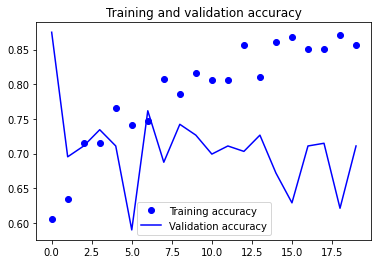

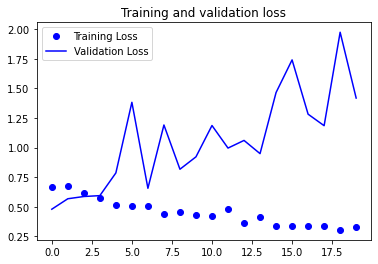

In [22]:
# Plot the results of training with data augmentation
plot_loss_acc(history)